In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from datetime import datetime

# 1) Loading the dataset
Loading the dataset and removing columns that are not needed.

In [3]:
# load the ED visits dataset with all the features
df_event_log_visits = pd.read_csv('df_visits_dur_timeofday.csv')

In [4]:
# dropping columns that were added earlier for analytics
df_event_log_visits.drop(['Duration', 'Duration_seconds', 'Earliest_Time'], axis=1, inplace=True)

In [5]:
# the end_time as it currently is in my dataset is not correct it was used earlier do infer the whole duration of a case (visit_id).
# given this I need to change this column to be a start_time of the next activity within a case

# Ensuring the DataFrame is sorted by 'VISIT_ID' and 'Start_Time' for correct computation
df_event_log_visits.sort_values(by=['VISIT_ID', 'Start_Time'], inplace=True)

# Shifting the 'Start_Time' of the next activity to the 'End_Time' column within each 'VISIT_ID'
df_event_log_visits['End_Time'] = df_event_log_visits.groupby('VISIT_ID')['Start_Time'].shift(-1)

# Displaying the first few rows to verify the changes
df_event_log_visits[['VISIT_ID', 'Start_Time', 'End_Time']].head()


,VISIT_ID,Start_Time,End_Time
35406,VISIT2208402,2022-04-01 00:22:00+00:00,2022-04-01 00:24:00+00:00
35407,VISIT2208402,2022-04-01 00:24:00+00:00,2022-04-01 00:30:00+00:00
35408,VISIT2208402,2022-04-01 00:30:00+00:00,2022-04-01 00:55:00+00:00
35409,VISIT2208402,2022-04-01 00:55:00+00:00,NaN
213493,VISIT2208404,2022-04-01 00:40:00+00:00,2022-04-01 00:44:00+00:00


In [6]:
# these are the remaining columns in the dataset as of now
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301212 entries, 35406 to 148396
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      301212 non-null  object 
 1   SEX                      301212 non-null  object 
 2   DOB                      301208 non-null  object 
 3   DOD                      11463 non-null   object 
 4   ED_POSTAL_CODE           300415 non-null  object 
 5   FACILITY_ID              301212 non-null  object 
 6   FACILITY_NAME            301212 non-null  object 
 7   VISIT_ID                 301212 non-null  object 
 8   VISIT_AGE                301208 non-null  float64
 9   CTAS                     298986 non-null  float64
 10  DEPART_DISPOSITION_ID    300782 non-null  object 
 11  DEPART_DISPOSITION_DESC  300782 non-null  object 
 12  Activity                 301212 non-null  object 
 13  Start_Time               301212 non-null  object 
 14  End_T

# 2) Dealing with missing values

## DOB

In [7]:
# DOB is the first column with missing values - there are in total for rows 4 missing values - these rows can be droppped

#  Removing records with missing DOB
df_event_log_visits = df_event_log_visits.dropna(subset=['DOB'])

df_event_log_visits.info()



# Next is DOD, however the missing value in this case indicates that the patient is still alive, hence getting rid of these values 
# would lead to losing important information - this column will be dealt with in later step.


<class 'pandas.core.frame.DataFrame'>
Index: 301208 entries, 35406 to 148396
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      301208 non-null  object 
 1   SEX                      301208 non-null  object 
 2   DOB                      301208 non-null  object 
 3   DOD                      11463 non-null   object 
 4   ED_POSTAL_CODE           300411 non-null  object 
 5   FACILITY_ID              301208 non-null  object 
 6   FACILITY_NAME            301208 non-null  object 
 7   VISIT_ID                 301208 non-null  object 
 8   VISIT_AGE                301208 non-null  float64
 9   CTAS                     298982 non-null  float64
 10  DEPART_DISPOSITION_ID    300778 non-null  object 
 11  DEPART_DISPOSITION_DESC  300778 non-null  object 
 12  Activity                 301208 non-null  object 
 13  Start_Time               301208 non-null  object 
 14  End_T

## POSTAL_CODE

In [8]:
# Another column with missing values is the postal code, in this case I decided to fill in the values based on the value of the hospital
# that the patient visited

# Filtering the df to only include rows where ED_POSTAL_CODE is missing
missing_postal_code = df_event_log_visits[df_event_log_visits['ED_POSTAL_CODE'].isnull()]

# Printing the rows with missing ED_POSTAL_CODE
print(missing_postal_code)

               SID SEX         DOB  DOD ED_POSTAL_CODE FACILITY_ID  \
293718  STDY765453   M  1990-08-22  NaN            NaN         GBC   
293719  STDY765453   M  1990-08-22  NaN            NaN         GBC   
293720  STDY765453   M  1990-08-22  NaN            NaN         GBC   
293721  STDY765453   M  1990-08-22  NaN            NaN         GBC   
293655  STDY765432   M  1958-07-25  NaN            NaN         SCM   
...            ...  ..         ...  ...            ...         ...   
301203  STDY768042   F  1976-12-17  NaN            NaN         SCM   
301204  STDY768042   F  1976-12-17  NaN            NaN         SCM   
301205  STDY768042   F  1976-12-17  NaN            NaN         SCM   
301206  STDY768042   F  1976-12-17  NaN            NaN         SCM   
301207  STDY768042   F  1976-12-17  NaN            NaN         SCM   

                                         FACILITY_NAME      VISIT_ID  \
293718  Dr. G.B. Cross Memorial Hospital - Clarenville  VISIT2212299   
293719  Dr. G.B

In [9]:
# Counting occurrences of each FACILITY_ID in the DataFrame with missing postal codes
facility_counts = missing_postal_code['FACILITY_ID'].value_counts()

# Printing the counts
print(facility_counts)


FACILITY_ID
HSC    414
SCM    220
GBC    111
CGH     41
BUR     11
Name: count, dtype: int64


In [10]:
facility_postal_map = {
    'HSC': 'A1B 3V6',
    'GBC': 'A5A 1K3',
    'SCM': 'A1C 5B8',
    'BUR': 'A0E 1E0',
    'CGH': 'A1Y 1A4'
}

# Applying the map to the 'FACILITY_ID' column to create a new 'Imputed_Postal_Code' column
df_event_log_visits['Imputed_Postal_Code'] = df_event_log_visits['FACILITY_ID'].map(facility_postal_map)

# Filling missing 'ED_POSTAL_CODE' values with the imputed values from 'Imputed_Postal_Code'
df_event_log_visits['ED_POSTAL_CODE'].fillna(df_event_log_visits['Imputed_Postal_Code'], inplace=True)

# dropping the column
df_event_log_visits.drop('Imputed_Postal_Code', axis=1, inplace=True)


In [11]:
# Checking if there are any remaining missing values in 'ED_POSTAL_CODE'
print(df_event_log_visits['ED_POSTAL_CODE'].isnull().sum())


0


In [12]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301208 entries, 35406 to 148396
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      301208 non-null  object 
 1   SEX                      301208 non-null  object 
 2   DOB                      301208 non-null  object 
 3   DOD                      11463 non-null   object 
 4   ED_POSTAL_CODE           301208 non-null  object 
 5   FACILITY_ID              301208 non-null  object 
 6   FACILITY_NAME            301208 non-null  object 
 7   VISIT_ID                 301208 non-null  object 
 8   VISIT_AGE                301208 non-null  float64
 9   CTAS                     298982 non-null  float64
 10  DEPART_DISPOSITION_ID    300778 non-null  object 
 11  DEPART_DISPOSITION_DESC  300778 non-null  object 
 12  Activity                 301208 non-null  object 
 13  Start_Time               301208 non-null  object 
 14  End_T

## CTAS

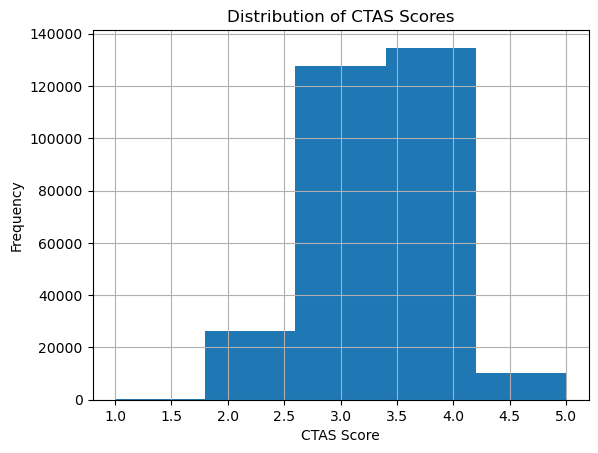

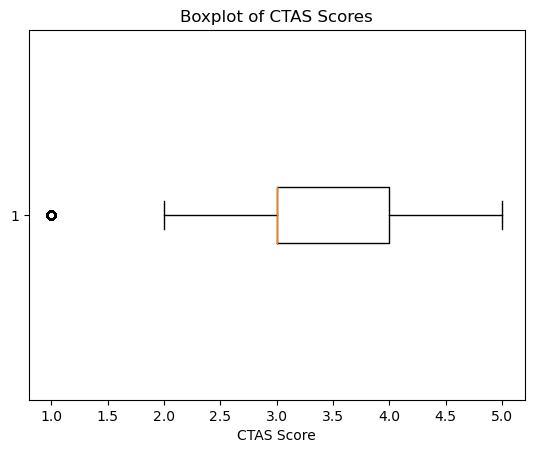

count    298982.000000
mean          3.430344
std           0.702471
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: CTAS, dtype: float64


In [13]:
# Next missing values are in the case of CTAS column 

# Histogram to see the distribution of CTAS scores
df_event_log_visits['CTAS'].hist(bins=5)
plt.title('Distribution of CTAS Scores')
plt.xlabel('CTAS Score')
plt.ylabel('Frequency')
plt.show()

# Boxplot to see the spread and check for outliers
plt.boxplot(df_event_log_visits['CTAS'].dropna(), vert=False)
plt.title('Boxplot of CTAS Scores')
plt.xlabel('CTAS Score')
plt.show()

# Descriptive statistics
print(df_event_log_visits['CTAS'].describe())


After imputation, remaining missing values in 'CTAS': 0


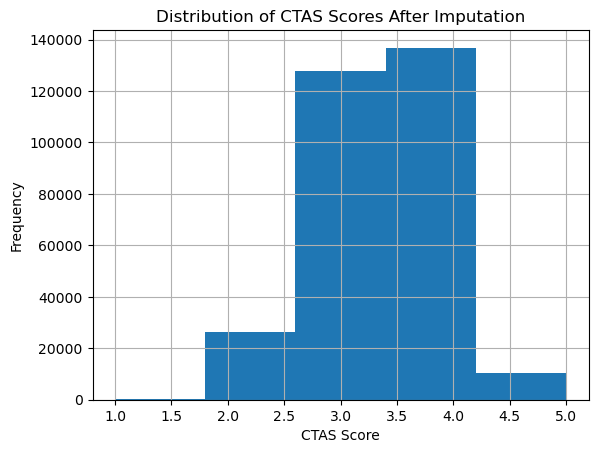

In [14]:
mode_ctas = df_event_log_visits['CTAS'].mode()[0]
mode_ctas

# Imputing missing values with the mode
df_event_log_visits['CTAS'].fillna(mode_ctas, inplace=True)

# Verifying no missing values
print(f"After imputation, remaining missing values in 'CTAS': {df_event_log_visits['CTAS'].isnull().sum()}")

# the distribution after imputation
df_event_log_visits['CTAS'].hist(bins=5)
plt.title('Distribution of CTAS Scores After Imputation')
plt.xlabel('CTAS Score')
plt.ylabel('Frequency')
plt.show()

In [15]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301208 entries, 35406 to 148396
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      301208 non-null  object 
 1   SEX                      301208 non-null  object 
 2   DOB                      301208 non-null  object 
 3   DOD                      11463 non-null   object 
 4   ED_POSTAL_CODE           301208 non-null  object 
 5   FACILITY_ID              301208 non-null  object 
 6   FACILITY_NAME            301208 non-null  object 
 7   VISIT_ID                 301208 non-null  object 
 8   VISIT_AGE                301208 non-null  float64
 9   CTAS                     301208 non-null  float64
 10  DEPART_DISPOSITION_ID    300778 non-null  object 
 11  DEPART_DISPOSITION_DESC  300778 non-null  object 
 12  Activity                 301208 non-null  object 
 13  Start_Time               301208 non-null  object 
 14  End_T

## DEPART_DISPOSITION_ID

In [16]:
# Departing disposition is one of the values I will be predicting with the model 
# (TRIAGED LEFT W/O BEING SEEN and REGISTERED LEFT W/O BEING SEEN)
# hence I decided to not deal with the missing values at this moment - however, we only need one of the columns
df_event_log_visits['DEPART_DISPOSITION_DESC'].unique()

array(['DISCHARGED W/O SUPPORT SERV', 'ADMITTED',
       'TRIAGED LEFT W/O BEING SEEN', 'TRANSFER TO OTHER',
       'REGISTERED LEFT W/O BEING SEEN', 'LEFT AGAINST MEDICAL ADVICE',
       'INIT RX LEFT BEFORE COMPLETE', 'ASSESSED LEFT BEFORE TREATMENT',
       'DIED IN FACILITY', 'TRANSFER TO CONTINUING CARE', nan,
       'TRANSFER TO OTHER ACUTE CARE', 'DISCHARGED WITH SUPPORT SERV',
       'TRANSFER TO LONG TERM CARE', 'TRSF TO CORRECTIONAL FACILITY'],
      dtype=object)

In [17]:
df_event_log_visits.drop(['DEPART_DISPOSITION_DESC'], axis=1, inplace=True)

In [18]:
dispositions_counts =  df_event_log_visits['DEPART_DISPOSITION_ID'].value_counts()

# Print the counts
print(dispositions_counts)

DEPART_DISPOSITION_ID
D        245904
TLWBS     32484
ADM       16861
TTO        3027
ITLBC       878
RLWBS       770
AMA         347
TA          152
EXP         127
ALBT        111
DS           47
TC           45
TL           14
TCC          11
Name: count, dtype: int64


# 3) Preprocessing columns
In the next steps I am preprocessing and cleaning data in all columns that will be used by the deep learning model.

## SEX

In [19]:
# preprocessing the SEX column

df_event_log_visits['SEX'].value_counts()

SEX
F    166092
M    135055
U        61
Name: count, dtype: int64

In [20]:
# Encode 'M' as 0 and 'F' as 1 and 'U' as 2
df_event_log_visits['SEX'] = df_event_log_visits['SEX'].map({'M': 0, 'F': 1, 'U': 2})
df_event_log_visits

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,DEPART_DISPOSITION_ID,Activity,Start_Time,End_Time,Duration_hours,TIME_OF_THE_DAY
35406,STDY147061,1,1959-07-14,NaN,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,Triage,2022-04-01 00:22:00+00:00,2022-04-01 00:24:00+00:00,0.550000,Early Morning to Morning
35407,STDY147061,1,1959-07-14,NaN,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,Providing service,2022-04-01 00:24:00+00:00,2022-04-01 00:30:00+00:00,0.550000,Early Morning to Morning
35408,STDY147061,1,1959-07-14,NaN,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,Assessment,2022-04-01 00:30:00+00:00,2022-04-01 00:55:00+00:00,0.550000,Early Morning to Morning
35409,STDY147061,1,1959-07-14,NaN,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,Patient departed,2022-04-01 00:55:00+00:00,NaN,0.550000,Early Morning to Morning
213493,STDY321073,0,1999-02-08,NaN,A1B 1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,D,Triage,2022-04-01 00:40:00+00:00,2022-04-01 00:44:00+00:00,5.333333,Early Morning to Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259174,STDY586460,1,1989-07-22,NaN,A1B 0G5,HSC,Health Sciences Centre - St. Johns,VISIT2377969,33.750000,4.0,TLWBS,Patient departed,2023-05-01 02:30:00+00:00,NaN,2.750000,Evening to Night
148393,STDY258323,1,1961-03-12,NaN,A1E 3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,D,Triage,2023-04-30 23:45:00+00:00,2023-04-30 23:52:00+00:00,8.233333,Evening to Night
148394,STDY258323,1,1961-03-12,NaN,A1E 3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,D,Providing service,2023-04-30 23:52:00+00:00,2023-05-01 07:50:00+00:00,8.233333,Evening to Night
148395,STDY258323,1,1961-03-12,NaN,A1E 3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,D,Assessment,2023-05-01 07:50:00+00:00,2023-05-01 07:59:00+00:00,8.233333,Evening to Night


## DATE OF BIRTH

In [21]:
# preprocessing the DOB column

# converting the 'DOB' column to datetime
df_event_log_visits['DOB'] = pd.to_datetime(df_event_log_visits['DOB'])


## 3.1) Creating new features based on the old features
Here, I am creating new features based on the available features in the dataset.

## DATE OF DEATH and IS_DECEASED

In [22]:
# Preprocessing the DOD column by creating a binary indicator from DOD
df_event_log_visits['Is_Deceased'] = df_event_log_visits['DOD'].notnull().astype(int)

df_event_log_visits['DOD'] = pd.to_datetime(df_event_log_visits['DOD'], errors='coerce')

df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301208 entries, 35406 to 148396
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   SID                    301208 non-null  object        
 1   SEX                    301208 non-null  int64         
 2   DOB                    301208 non-null  datetime64[ns]
 3   DOD                    11463 non-null   datetime64[ns]
 4   ED_POSTAL_CODE         301208 non-null  object        
 5   FACILITY_ID            301208 non-null  object        
 6   FACILITY_NAME          301208 non-null  object        
 7   VISIT_ID               301208 non-null  object        
 8   VISIT_AGE              301208 non-null  float64       
 9   CTAS                   301208 non-null  float64       
 10  DEPART_DISPOSITION_ID  300778 non-null  object        
 11  Activity               301208 non-null  object        
 12  Start_Time             301208 non-null  objec

## AREA_TYPE

In [23]:
# identifying rural or urban area based on the postal code according to
# https://www.canadapost-postescanada.ca/cpc/en/support/articles/addressing-guidelines/postal-codes.page

# Function to determine if a postal code is urban or rural
def urban_rural_classifier(postal_code):
    # Check the second character of the postal code
    if postal_code[1] == '0':
        return 'rural'
    else:
        return 'urban'

# Apply the function to classify each postal code
df_event_log_visits['Area_Type'] = df_event_log_visits['ED_POSTAL_CODE'].apply(urban_rural_classifier)

# Verify by displaying the DataFrame
print(df_event_log_visits[['ED_POSTAL_CODE', 'Area_Type']].head())

       ED_POSTAL_CODE Area_Type
35406         A0A 2B0     rural
35407         A0A 2B0     rural
35408         A0A 2B0     rural
35409         A0A 2B0     rural
213493        A1B 1Z6     urban


In [24]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301208 entries, 35406 to 148396
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   SID                    301208 non-null  object        
 1   SEX                    301208 non-null  int64         
 2   DOB                    301208 non-null  datetime64[ns]
 3   DOD                    11463 non-null   datetime64[ns]
 4   ED_POSTAL_CODE         301208 non-null  object        
 5   FACILITY_ID            301208 non-null  object        
 6   FACILITY_NAME          301208 non-null  object        
 7   VISIT_ID               301208 non-null  object        
 8   VISIT_AGE              301208 non-null  float64       
 9   CTAS                   301208 non-null  float64       
 10  DEPART_DISPOSITION_ID  300778 non-null  object        
 11  Activity               301208 non-null  object        
 12  Start_Time             301208 non-null  objec

## COORDINATES

In [25]:
# adding latutide and longitude table from geonames
file_path = 'CA_full.txt'
postal_codes = pd.read_csv(file_path, delimiter='\t', names=[
    'Country', 'Postal_Code', 'Place_Name', 'Province', 'Province_Code',
    'Unnamed5', 'Unnamed6', 'Unnamed7', 'Unnamed8', 'Latitude', 'Longitude', 'Extra'
], skiprows=1)  # skiprows=1 to skip the example header row you pasted

# Dropping the unnecessary columns
postal_codes.drop(columns=['Unnamed5', 'Unnamed6', 'Unnamed7', 'Unnamed8', 'Extra'], inplace=True)

# Displaying the dataframe to ensure it loaded correctly
print(postal_codes.head())


  Country Postal_Code    Place_Name Province Province_Code  Latitude  \
0      CA     T0A 0A1   Saddle Lake  Alberta            AB   54.0029   
1      CA     T0A 0A2  Cherry Grove  Alberta            AB   54.3603   
2      CA     T0A 0A3       Glendon  Alberta            AB   54.3455   
3      CA     T0A 0A4     Lindbergh  Alberta            AB   54.3455   
4      CA     T0A 0A5       St Lina  Alberta            AB   54.3455   

   Longitude  
0  -111.7000  
1  -110.0863  
2  -111.6157  
3  -111.6157  
4  -111.6157  


In [26]:
# checking for duplicates 

print(postal_codes['Postal_Code'].duplicated().sum())
postal_codes = postal_codes.drop_duplicates(subset=['Postal_Code'], keep='first')


891


In [27]:
# Merging the dataframes
df_event_log_visits = df_event_log_visits.merge(postal_codes, left_on='ED_POSTAL_CODE', right_on='Postal_Code', how='left')

# Checking for missing latitude and longitude after the merge
print(df_event_log_visits[['Latitude', 'Longitude']].isnull().sum())


Latitude     4692
Longitude    4692
dtype: int64


In [28]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301208 entries, 0 to 301207
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   SID                    301208 non-null  object        
 1   SEX                    301208 non-null  int64         
 2   DOB                    301208 non-null  datetime64[ns]
 3   DOD                    11463 non-null   datetime64[ns]
 4   ED_POSTAL_CODE         301208 non-null  object        
 5   FACILITY_ID            301208 non-null  object        
 6   FACILITY_NAME          301208 non-null  object        
 7   VISIT_ID               301208 non-null  object        
 8   VISIT_AGE              301208 non-null  float64       
 9   CTAS                   301208 non-null  float64       
 10  DEPART_DISPOSITION_ID  300778 non-null  object        
 11  Activity               301208 non-null  object        
 12  Start_Time             301208 non-null  obje

In [29]:
# some of the postal codes can not be found on geonames as they are - the closest coordinates can be found by using
# only the first three digits
postal_codes['First_3_Digits'] = postal_codes['Postal_Code'].str[:3]


In [30]:
# rows where 'Latitude' or 'Longitude' is missing 
df_event_log_visits_missing_lat = df_event_log_visits[df_event_log_visits['Latitude'].isnull() | df_event_log_visits['Longitude'].isnull()]

# creating nnew column
df_event_log_visits_missing_lat['First_3_Digits'] = df_event_log_visits['ED_POSTAL_CODE'].str[:3]
df_event_log_visits_missing_lat

C:\Users\ksteflova\AppData\Local\Temp\ipykernel_8584\2478119479.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event_log_visits_missing_lat['First_3_Digits'] = df_event_log_visits['ED_POSTAL_CODE'].str[:3]


,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Is_Deceased,Area_Type,Country,Postal_Code,Place_Name,Province,Province_Code,Latitude,Longitude,First_3_Digits
499,STDY162569,1,1991-06-04,NaT,A1L 5V6,HSC,Health Sciences Centre - St. Johns,VISIT2208684,30.833333,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1L
500,STDY162569,1,1991-06-04,NaT,A1L 5V6,HSC,Health Sciences Centre - St. Johns,VISIT2208684,30.833333,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1L
501,STDY162569,1,1991-06-04,NaT,A1L 5V6,HSC,Health Sciences Centre - St. Johns,VISIT2208684,30.833333,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1L
563,STDY293437,0,1958-04-04,NaT,A5A 0H3,GBC,Dr. G.B. Cross Memorial Hospital - Clarenville,VISIT2208721,64.000000,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5A
564,STDY293437,0,1958-04-04,NaT,A5A 0H3,GBC,Dr. G.B. Cross Memorial Hospital - Clarenville,VISIT2208721,64.000000,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300430,STDY167108,1,1994-09-20,NaT,A5A 0K1,GBC,Dr. G.B. Cross Memorial Hospital - Clarenville,VISIT2377489,28.583333,3.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5A
301094,STDY348394,0,2017-05-29,NaT,A5A 0H8,GBC,Dr. G.B. Cross Memorial Hospital - Clarenville,VISIT2377906,5.916667,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5A
301095,STDY348394,0,2017-05-29,NaT,A5A 0H8,GBC,Dr. G.B. Cross Memorial Hospital - Clarenville,VISIT2377906,5.916667,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5A
301096,STDY348394,0,2017-05-29,NaT,A5A 0H8,GBC,Dr. G.B. Cross Memorial Hospital - Clarenville,VISIT2377906,5.916667,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5A


In [31]:

# Merging the missing latitude/longitude DataFrame with postal_codes to get the corresponding latitude/longitude
df_merged = df_event_log_visits_missing_lat.merge(postal_codes, on='First_3_Digits', how='left', suffixes=('', '_pc'))

# Displaying the merged DataFrame
print(df_merged.head())


          SID  SEX        DOB DOD ED_POSTAL_CODE FACILITY_ID  \
0  STDY162569    1 1991-06-04 NaT        A1L 5V6         HSC   
1  STDY162569    1 1991-06-04 NaT        A1L 5V6         HSC   
2  STDY162569    1 1991-06-04 NaT        A1L 5V6         HSC   
3  STDY162569    1 1991-06-04 NaT        A1L 5V6         HSC   
4  STDY162569    1 1991-06-04 NaT        A1L 5V6         HSC   

                        FACILITY_NAME      VISIT_ID  VISIT_AGE  CTAS  ...  \
0  Health Sciences Centre - St. Johns  VISIT2208684  30.833333   4.0  ...   
1  Health Sciences Centre - St. Johns  VISIT2208684  30.833333   4.0  ...   
2  Health Sciences Centre - St. Johns  VISIT2208684  30.833333   4.0  ...   
3  Health Sciences Centre - St. Johns  VISIT2208684  30.833333   4.0  ...   
4  Health Sciences Centre - St. Johns  VISIT2208684  30.833333   4.0  ...   

  Latitude Longitude First_3_Digits Country_pc  Postal_Code_pc Place_Name_pc  \
0      NaN       NaN            A1L         CA         A1L 0A2      Para

In [32]:
# adding new column to the original dataset to merge on
df_event_log_visits['First_3_Digits'] = df_event_log_visits['ED_POSTAL_CODE'].str[:3]
df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Is_Deceased,Area_Type,Country,Postal_Code,Place_Name,Province,Province_Code,Latitude,Longitude,First_3_Digits
0,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,CA,A0A 2B0,Cupids,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A
1,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,CA,A0A 2B0,Cupids,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A
2,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,CA,A0A 2B0,Cupids,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A
3,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,CA,A0A 2B0,Cupids,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A
4,STDY321073,0,1999-02-08,NaT,A1B 1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,...,0,urban,CA,A1B 1Z6,St. John's,Newfoundland and Labrador,NL,47.5679,-52.7422,A1B


In [33]:
# Find the rows in the main dataset where latitude and longitude are missing
missing_indices = df_event_log_visits[df_event_log_visits['Latitude'].isna() & df_event_log_visits['Longitude'].isna()].index

# Update the main dataset with the latitude and longitude from the merged DataFrame
df_event_log_visits.loc[missing_indices, 'Latitude'] = df_merged['Latitude_pc']
df_event_log_visits.loc[missing_indices, 'Longitude'] = df_merged['Longitude_pc']

# Check if the missing values are updated
print(df_event_log_visits.loc[missing_indices, ['First_3_Digits', 'Latitude', 'Longitude']])


       First_3_Digits  Latitude  Longitude
499               A1L   47.5410   -52.8749
500               A1L   47.5421   -52.8741
501               A1L   47.5426   -52.8727
563               A5A   47.5474   -52.9002
564               A5A   47.5477   -52.9048
...               ...       ...        ...
300430            A5A   47.5947   -52.7043
301094            A5A   47.6012   -52.7123
301095            A5A   47.6039   -52.7151
301096            A5A   47.6039   -52.7167
301097            A5A   47.6019   -52.7379

[4692 rows x 3 columns]


In [34]:
# an overview of all missing values in the DataFrame
print(df_event_log_visits.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301208 entries, 0 to 301207
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   SID                    301208 non-null  object        
 1   SEX                    301208 non-null  int64         
 2   DOB                    301208 non-null  datetime64[ns]
 3   DOD                    11463 non-null   datetime64[ns]
 4   ED_POSTAL_CODE         301208 non-null  object        
 5   FACILITY_ID            301208 non-null  object        
 6   FACILITY_NAME          301208 non-null  object        
 7   VISIT_ID               301208 non-null  object        
 8   VISIT_AGE              301208 non-null  float64       
 9   CTAS                   301208 non-null  float64       
 10  DEPART_DISPOSITION_ID  300778 non-null  object        
 11  Activity               301208 non-null  object        
 12  Start_Time             301208 non-null  obje

In [35]:
# Dropping rows where either Latitude or Longitude is missing (3 rows)
df_event_log_visits = df_event_log_visits.dropna(subset=['Latitude', 'Longitude'])

# Verifying the result
print(df_event_log_visits[['Latitude', 'Longitude']].isnull().sum())


Latitude     0
Longitude    0
dtype: int64


## DISTANCE_TO_HOSPITAL

In [36]:
from geopy.distance import geodesic

# Hospital coordinates dictionary (includes all hospitals)
hospital_coords = {
    'Health Sciences Centre - St. Johns': (47.57173844188426, -52.7428752808959),
    'St. Clares Mercy Hospital - St. Johns': (47.55783035337661, -52.72164112844875),
    'Dr. G.B. Cross Memorial Hospital - Clarenville': (48.165186482963676, -53.98449946306605),
    'Carbonear General Hospital - Carbonear': (47.725414948091, -53.226560474732224),
    'Burin Peninsula Health care Centre - Burin': (47.10500591911938, -55.19465935942642),  
}

# Calculating the distance between a case and a hospital
def calculate_distance(row, hospital_name):
    case_coords = (row['Latitude'], row['Longitude'])
    hospital_coords_tuple = hospital_coords.get(hospital_name, None)  
    if hospital_coords_tuple is None:
        return float('nan')  # Return NaN if the hospital isn't in the dictionary
    return geodesic(case_coords, hospital_coords_tuple).km  # Distance in kilometers

# Applying the function to calculate distances for all hospitals
df_event_log_visits['Distance_to_Hospital'] = df_event_log_visits.apply(
    lambda row: calculate_distance(row, row['FACILITY_NAME']),
    axis=1
)

# Displaying DataFrame with the calculated distances
print(df_event_log_visits[['VISIT_ID', 'FACILITY_NAME', 'Distance_to_Hospital']].head())


       VISIT_ID                           FACILITY_NAME  Distance_to_Hospital
0  VISIT2208402  Carbonear General Hospital - Carbonear              22.23370
1  VISIT2208402  Carbonear General Hospital - Carbonear              22.23370
2  VISIT2208402  Carbonear General Hospital - Carbonear              22.23370
3  VISIT2208402  Carbonear General Hospital - Carbonear              22.23370
4  VISIT2208404      Health Sciences Centre - St. Johns               0.42978


## IS_NL_HOLIDAY

In [37]:
# List of Newfoundland and Labrador holidays in "MM-DD" format
nl_holidays = {
    "01-01",  # New Year's Day
    "03-17",  # St. Patrick's Day
    "04-23",  # St. George's Day
    "06-24",  # Discovery Day
    "07-01",  # Canada Day
    "09-02",  # Labour Day
    "10-14",  # Thanksgiving
    "11-11",  # Remembrance Day
    "12-25",  # Christmas Day
    "12-26"   # Boxing Day
}

# checking if a given date matches a holiday
def is_nl_holiday(date):
    # Extracting month and day from the date
    month_day = date.strftime("%m-%d")
    return month_day in nl_holidays


In [38]:
# Converting 'Start_Time' to datetime 
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])

# Applying the function to create a new column
df_event_log_visits['Is_NL_Holiday'] = df_event_log_visits['Start_Time'].apply(is_nl_holiday)

# Displaying results
print(df_event_log_visits[['Start_Time', 'Is_NL_Holiday']].head())



                 Start_Time  Is_NL_Holiday
0 2022-04-01 00:22:00+00:00          False
1 2022-04-01 00:24:00+00:00          False
2 2022-04-01 00:30:00+00:00          False
3 2022-04-01 00:55:00+00:00          False
4 2022-04-01 00:40:00+00:00          False


## DAY_OF_WEEK and IS_WEEKEND

In [39]:
# Getting the day of the week (0 = Monday, 6 = Sunday)
df_event_log_visits['Day_of_Week'] = pd.to_datetime(df_event_log_visits['Start_Time']).dt.dayofweek
df_event_log_visits['Is_Weekend'] = df_event_log_visits['Day_of_Week'].isin([5, 6])


In [40]:
df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Place_Name,Province,Province_Code,Latitude,Longitude,First_3_Digits,Distance_to_Hospital,Is_NL_Holiday,Day_of_Week,Is_Weekend
0,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,Cupids,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A,22.23370,False,4,False
1,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,Cupids,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A,22.23370,False,4,False
2,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,Cupids,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A,22.23370,False,4,False
3,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,Cupids,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A,22.23370,False,4,False
4,STDY321073,0,1999-02-08,NaT,A1B 1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,...,St. John's,Newfoundland and Labrador,NL,47.5679,-52.7422,A1B,0.42978,False,4,False


## VISIT_SEASON

In [41]:
# Defining season ranges
seasons = {
    "Winter": (1, 2, 12),
    "Spring": (3, 4, 5),
    "Summer": (6, 7, 8),
    "Fall": (9, 10, 11)
}

# Function to get the season
def get_season(month):
    for season, months in seasons.items():
        if month in months:
            return season
    return None

df_event_log_visits['Visit_Season'] = df_event_log_visits['Start_Time'].apply(
    lambda x: get_season(pd.to_datetime(x).month)
)


In [42]:
df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Province,Province_Code,Latitude,Longitude,First_3_Digits,Distance_to_Hospital,Is_NL_Holiday,Day_of_Week,Is_Weekend,Visit_Season
0,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A,22.23370,False,4,False,Spring
1,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A,22.23370,False,4,False,Spring
2,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A,22.23370,False,4,False,Spring
3,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A,22.23370,False,4,False,Spring
4,STDY321073,0,1999-02-08,NaT,A1B 1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,...,Newfoundland and Labrador,NL,47.5679,-52.7422,A1B,0.42978,False,4,False,Spring


## VISIT_FREQUENCY

In [43]:
# Calculating the frequency of visits for each unique 'SID' 
visit_counts = df_event_log_visits['SID'].value_counts()
# Mapping the visit counts to the 'SID' column to create a new 'Visit_Frequency' column
df_event_log_visits['Visit_Frequency'] = df_event_log_visits['SID'].map(visit_counts)
df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Province_Code,Latitude,Longitude,First_3_Digits,Distance_to_Hospital,Is_NL_Holiday,Day_of_Week,Is_Weekend,Visit_Season,Visit_Frequency
0,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NL,47.5267,-53.2597,A0A,22.23370,False,4,False,Spring,21
1,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NL,47.5267,-53.2597,A0A,22.23370,False,4,False,Spring,21
2,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NL,47.5267,-53.2597,A0A,22.23370,False,4,False,Spring,21
3,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,NL,47.5267,-53.2597,A0A,22.23370,False,4,False,Spring,21
4,STDY321073,0,1999-02-08,NaT,A1B 1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,...,NL,47.5679,-52.7422,A1B,0.42978,False,4,False,Spring,4


In [44]:
# All rows from the DataFrame where 'DEPART_DISPOSITION_ID' is 'TLWBS' or 'RLWBS'
lwbs_history = df_event_log_visits[df_event_log_visits['DEPART_DISPOSITION_ID'].isin(['TLWBS', 'RLWBS'])]

# Counting the number of 'SID' values in the filtered data to get the LWBS (Left Without Being Seen) history for each patient
lwbs_counts = lwbs_history['SID'].value_counts()

# Mapping the LWBS counts to 'SID' in the original DataFrame, filling missing values with zero
df_event_log_visits['Prior_LWBS'] = df_event_log_visits['SID'].map(lwbs_counts).fillna(0)


df_event_log_visits.head()


,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Latitude,Longitude,First_3_Digits,Distance_to_Hospital,Is_NL_Holiday,Day_of_Week,Is_Weekend,Visit_Season,Visit_Frequency,Prior_LWBS
0,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,47.5267,-53.2597,A0A,22.23370,False,4,False,Spring,21,0.0
1,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,47.5267,-53.2597,A0A,22.23370,False,4,False,Spring,21,0.0
2,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,47.5267,-53.2597,A0A,22.23370,False,4,False,Spring,21,0.0
3,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,47.5267,-53.2597,A0A,22.23370,False,4,False,Spring,21,0.0
4,STDY321073,0,1999-02-08,NaT,A1B 1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,...,47.5679,-52.7422,A1B,0.42978,False,4,False,Spring,4,0.0


## ED_BUSINESS_HOURLY

In [45]:

# Groupping by hour to get the number of patient arrivals in each hour
arrival_counts = df_event_log_visits.groupby(df_event_log_visits['Start_Time'].dt.floor('H')).size()

# Mappinng the hourly counts back to the original DataFrame
df_event_log_visits['ED_Business_Hourly'] = df_event_log_visits['Start_Time'].dt.floor('H').map(arrival_counts)


print(df_event_log_visits[['Start_Time', 'ED_Business_Hourly']].head())


                 Start_Time  ED_Business_Hourly
0 2022-04-01 00:22:00+00:00                   8
1 2022-04-01 00:24:00+00:00                   8
2 2022-04-01 00:30:00+00:00                   8
3 2022-04-01 00:55:00+00:00                   8
4 2022-04-01 00:40:00+00:00                   8


In [46]:

df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Longitude,First_3_Digits,Distance_to_Hospital,Is_NL_Holiday,Day_of_Week,Is_Weekend,Visit_Season,Visit_Frequency,Prior_LWBS,ED_Business_Hourly
0,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,-53.2597,A0A,22.23370,False,4,False,Spring,21,0.0,8
1,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,-53.2597,A0A,22.23370,False,4,False,Spring,21,0.0,8
2,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,-53.2597,A0A,22.23370,False,4,False,Spring,21,0.0,8
3,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,-53.2597,A0A,22.23370,False,4,False,Spring,21,0.0,8
4,STDY321073,0,1999-02-08,NaT,A1B 1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,...,-52.7422,A1B,0.42978,False,4,False,Spring,4,0.0,8


## TOTAL_PRECIPITATION

In [47]:
# Load the four datasets from the government of Canada 
df1 = pd.read_csv("climate_dataset\climate-daily.csv")
df2 = pd.read_csv("climate_dataset\climate-daily (1).csv")
df3 = pd.read_csv("climate_dataset\climate-daily (2).csv")
df4 = pd.read_csv("climate_dataset\climate-daily (3).csv")

# Concatenating the datasets
newfoundland_weather_dataset = pd.concat([df1, df2, df3, df4], ignore_index=True)

# Displaying the combined dataset
print(newfoundland_weather_dataset.head())

# Saving the combined dataset
newfoundland_weather_dataset.to_csv("newfoundland_weather_dataset.csv", index=False)


           x          y  COOLING_DEGREE_DAYS  MIN_TEMPERATURE  \
0 -53.998173  47.310633                  NaN              NaN   
1 -53.998173  47.310633                  0.0             15.9   
2 -53.998173  47.310633                  0.0             15.7   
3 -53.998173  47.310633                  0.0             16.0   
4 -53.998173  47.310633                  0.0             16.2   

  COOLING_DEGREE_DAYS_FLAG                 ID  LOCAL_DAY SNOW_ON_GROUND_FLAG  \
0                        M  8400104.2022.7.22         22                 NaN   
1                      NaN  8400104.2022.7.23         23                 NaN   
2                      NaN  8400104.2022.7.24         24                 NaN   
3                      NaN  8400104.2022.7.25         25                 NaN   
4                      NaN  8400104.2022.7.26         26                 NaN   

  TOTAL_SNOW_FLAG  DIRECTION_MAX_GUST  ...  TOTAL_RAIN_FLAG  \
0             NaN                 NaN  ...              NaN   
1 

In [48]:
newfoundland_weather_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31627 entries, 0 to 31626
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   x                         31627 non-null  float64
 1   y                         31627 non-null  float64
 2   COOLING_DEGREE_DAYS       30418 non-null  float64
 3   MIN_TEMPERATURE           30423 non-null  float64
 4   COOLING_DEGREE_DAYS_FLAG  1200 non-null   object 
 5   ID                        31627 non-null  object 
 6   LOCAL_DAY                 31627 non-null  int64  
 7   SNOW_ON_GROUND_FLAG       471 non-null    object 
 8   TOTAL_SNOW_FLAG           718 non-null    object 
 9   DIRECTION_MAX_GUST        20213 non-null  float64
 10  SPEED_MAX_GUST            20710 non-null  float64
 11  TOTAL_PRECIPITATION       22565 non-null  float64
 12  TOTAL_PRECIPITATION_FLAG  5690 non-null   object 
 13  TOTAL_RAIN                5980 non-null   float64
 14  STATIO

In [49]:
# Extracting the date part from the 'ID' column and converting it to a suitable date format
newfoundland_weather_dataset['DATE'] = pd.to_datetime(newfoundland_weather_dataset['ID'].str.split('.').str[1:].str.join('.'))

# Printing the first few rows of the DataFrame to verify the changes
newfoundland_weather_dataset.head()


,x,y,COOLING_DEGREE_DAYS,MIN_TEMPERATURE,COOLING_DEGREE_DAYS_FLAG,ID,LOCAL_DAY,SNOW_ON_GROUND_FLAG,TOTAL_SNOW_FLAG,DIRECTION_MAX_GUST,...,MAX_REL_HUMIDITY_FLAG,HEATING_DEGREE_DAYS_FLAG,PROVINCE_CODE,MAX_TEMPERATURE_FLAG,MIN_REL_HUMIDITY_FLAG,DIRECTION_MAX_GUST_FLAG,LOCAL_MONTH,MIN_REL_HUMIDITY,CLIMATE_IDENTIFIER,DATE
0,-53.998173,47.310633,NaN,NaN,M,8400104.2022.7.22,22,NaN,NaN,NaN,...,M,M,NL,M,M,M,7,NaN,8400104,2022-07-22
1,-53.998173,47.310633,0.0,15.9,NaN,8400104.2022.7.23,23,NaN,NaN,17.0,...,NaN,NaN,NL,NaN,NaN,NaN,7,93.0,8400104,2022-07-23
2,-53.998173,47.310633,0.0,15.7,NaN,8400104.2022.7.24,24,NaN,NaN,17.0,...,NaN,NaN,NL,NaN,NaN,NaN,7,92.0,8400104,2022-07-24
3,-53.998173,47.310633,0.0,16.0,NaN,8400104.2022.7.25,25,NaN,NaN,17.0,...,NaN,NaN,NL,NaN,NaN,NaN,7,88.0,8400104,2022-07-25
4,-53.998173,47.310633,0.0,16.2,NaN,8400104.2022.7.26,26,NaN,NaN,17.0,...,NaN,NaN,NL,NaN,NaN,NaN,7,98.0,8400104,2022-07-26


In [50]:
# all the weather stations in the dataset
newfoundland_weather_dataset["STATION_NAME"].unique()

array(['ARGENTIA (AUT)', 'BADGER (AUT)', 'BONAVISTA', 'BURGEO NL',
       'BURNT POND', 'CAPE RACE (AUT)', 'CORMACK RCS', 'CORNER BROOK',
       "DANIEL'S HARBOUR", 'DEER LAKE', 'DEER LAKE A', 'ENGLEE (AUT)',
       'FEROLLE POINT (AUT)', 'GANDER INTL A', 'GANDER AIRPORT CS',
       'LA SCIE', 'LETHBRIDGE', 'MILLERTOWN RCS', 'PORT AUX BASQUES',
       'SAGONA ISLAND', 'ST. ANTHONY A', 'ST ANTHONY',
       "ST. JOHN'S INTL A", 'ST JOHNS WEST CLIMATE', 'ST LAWRENCE',
       'STEPHENVILLE A', 'STEPHENVILLE RCS', 'TERRA NOVA NAT PARK CS',
       'TWILLINGATE (AUT)', 'WINTERLAND BRANCH HILL', 'WRECKHOUSE',
       'GRATES COVE', 'POOLS ISLAND', 'MARTICOT ISLAND', 'CARTWRIGHT A',
       'CHURCHILL FALLS A', 'GOOSE BAY A', 'HOPEDALE (AUT)', 'MAKKOVIK A',
       "MARY'S HARBOUR A", 'NAIN', 'NAIN A', 'SAGLEK', 'WABUSH A'],
      dtype=object)

In [51]:
# Getting unique station names
unique_station_names = newfoundland_weather_dataset["STATION_NAME"].unique()

# Printing latitude (x) and longitude (y) for each station
for station_name in unique_station_names:
    # Filter dataset for the current station
    station_data = newfoundland_weather_dataset[newfoundland_weather_dataset["STATION_NAME"] == station_name]
    
    # Gettinng latitude and longitude values
    latitude = station_data["y"].iloc[0]  # Assuming latitude column name is "Latitude"
    longitude = station_data["x"].iloc[0]  # Assuming longitude column name is "Longitude"
    
    # Printing latitude and longitude
    print(f"Station: {station_name}, Latitude (x): {latitude}, Longitude (y): {longitude}")


Station: ARGENTIA (AUT), Latitude (x): 47.310632777777776, Longitude (y): -53.998173055555554
Station: BADGER (AUT), Latitude (x): 48.96666666666667, Longitude (y): -56.06666666666667
Station: BONAVISTA, Latitude (x): 48.66722222222222, Longitude (y): -53.11416666666667
Station: BURGEO NL, Latitude (x): 47.61666666666667, Longitude (y): -57.61666666666667
Station: BURNT POND, Latitude (x): 48.16666666666666, Longitude (y): -57.333333333333336
Station: CAPE RACE (AUT), Latitude (x): 46.66, Longitude (y): -53.076388888888886
Station: CORMACK RCS, Latitude (x): 49.321953055555554, Longitude (y): -57.39333611111111
Station: CORNER BROOK, Latitude (x): 48.93333333333333, Longitude (y): -57.91666666666666
Station: DANIEL'S HARBOUR, Latitude (x): 50.23583333333333, Longitude (y): -57.58083333333333
Station: DEER LAKE, Latitude (x): 49.16666666666666, Longitude (y): -57.43333333333333
Station: DEER LAKE A, Latitude (x): 49.20916666666667, Longitude (y): -57.394444444444446
Station: ENGLEE (AUT

In [52]:
from geopy.distance import geodesic

# these are the coordinates of the five hospitals
hospital_coords = {
    'Health Sciences Centre - St. Johns': (47.57173844188426, -52.7428752808959),
    'St. Clares Mercy Hospital - St. Johns': (47.55783035337661, -52.72164112844875),
    'Dr. G.B. Cross Memorial Hospital - Clarenville': (48.165186482963676, -53.98449946306605),
    'Carbonear General Hospital - Carbonear': (47.725414948091, -53.226560474732224),
    'Burin Peninsula Health care Centre - Burin': (47.10500591911938, -55.19465935942642)
}


# these are the coordinates of the all the weather stations
weather_station_coords = {
        'ARGENTIA (AUT)': (47.310632777777776, -53.998173055555554),
        'BADGER (AUT)': (48.96666666666667, -56.06666666666667),
        'BONAVISTA': (48.66722222222222, -53.11416666666667),
        'BURGEO NL': (47.61666666666667, -57.61666666666667),
        'BURNT POND': (48.16666666666666, -57.333333333333336),
        'CAPE RACE (AUT)': (46.66, -53.076388888888886),
        'CORMACK RCS': (49.321953055555554, -57.39333611111111),
        'CORNER BROOK': (48.93333333333333, -57.91666666666666),
        "DANIEL'S HARBOUR": (50.23583333333333, -57.58083333333333),
        'DEER LAKE': (49.16666666666666, -57.43333333333333),
        'DEER LAKE A': (49.20916666666667, -57.394444444444446),
        'ENGLEE (AUT)': (50.72111111111112, -56.11277777777778),
        'FEROLLE POINT (AUT)': (51.016666666666666, -57.1),
        'GANDER INTL A': (48.93694444444444, -54.56805555555555),
        'GANDER AIRPORT CS': (48.94611111111111, -54.566944444444445),
        'LA SCIE': (49.91666666666666, -55.66666666666666),
        'LETHBRIDGE': (48.35, -53.90166666666666),
        'MILLERTOWN RCS': (48.81669972222223, -56.543526388888885),
        'PORT AUX BASQUES': (47.57388888888889, -59.15472222222222),
        'SAGONA ISLAND': (47.367777777777775, -55.79472222222222),
        'ST. ANTHONY A': (51.39194444444445, -56.068888888888885),
        'ST ANTHONY': (51.38333333333333, -56.1),
        "ST. JOHN'S INTL A": (47.61861111111112, -52.7525),
        'ST JOHNS WEST CLIMATE': (47.51335555555556, -52.78333888888889),
        'ST LAWRENCE': (46.91666666666666, -55.38333333333333),
        'STEPHENVILLE A': (48.54138888888889, -58.55),
        'STEPHENVILLE RCS': (48.56138888888889, -58.56611111111111),
        'TERRA NOVA NAT PARK CS': (48.55694444444445, -53.97444444444445),
        'TWILLINGATE (AUT)': (49.68333333333333, -54.8),
        'WINTERLAND BRANCH HILL': (47.13611111111111, -55.32805555555556),
        'WRECKHOUSE': (47.711666666666666, -59.30833333333333),
        'GRATES COVE': (48.17194444444444, -52.939166666666665),
        'POOLS ISLAND': (49.11222222222222, -53.58111111111111),
        'MARTICOT ISLAND': (47.32833416666666, -54.58527805555556),
        'CARTWRIGHT A': (53.6825, -57.04194444444445),
        'CHURCHILL FALLS A': (53.56194444444444, -64.10638888888889),
        'GOOSE BAY A': (53.31666666666667, -60.416666666666)}

# Function to get coordinates of a weather station
def get_weather_station_coords(station_name):
    return weather_station_coords.get(station_name)


# Function to find the closest weather station for each hospital
def find_closest_weather_station(hospital_coords, weather_station_coords):
    closest_stations = {}
    
    # Looping through each hospital
    for hospital_name, hospital_coord in hospital_coords.items():
        closest_station = None
        closest_distance = float('inf')  # Start with a very large distance
        
        # Looping through each weather station
        for station_name, station_coord in weather_station_coords.items():
            # Calculate the geodesic distance between hospital and weather station
            distance = geodesic(hospital_coord, station_coord).km
            
            # Update if this station is closer
            if distance < closest_distance:
                closest_distance = distance
                closest_station = station_name
        
        # Store the closest station for the current hospital
        closest_stations[hospital_name] = closest_station
    
    return closest_stations



# Finding the closest weather station to each hospital
closest_stations = find_closest_weather_station(hospital_coords, weather_station_coords)

# Printing the closest weather station(s) for each hospital
for hospital, station in closest_stations.items():
    print(f"The closest weather station to {hospital} is {station}")

The closest weather station to Health Sciences Centre - St. Johns is ST. JOHN'S INTL A
The closest weather station to St. Clares Mercy Hospital - St. Johns is ST JOHNS WEST CLIMATE
The closest weather station to Dr. G.B. Cross Memorial Hospital - Clarenville is LETHBRIDGE
The closest weather station to Carbonear General Hospital - Carbonear is ST. JOHN'S INTL A
The closest weather station to Burin Peninsula Health care Centre - Burin is WINTERLAND BRANCH HILL


In [53]:
# Dictionary mapping weather stations to hospital names
station_to_hospital = {
    'ST. JOHN\'S INTL A': 'Health Sciences Centre - St. Johns',
    'ST JOHNS WEST CLIMATE': 'St. Clares Mercy Hospital - St. Johns',
    'LETHBRIDGE': 'Dr. G.B. Cross Memorial Hospital - Clarenville',
    'ST. JOHN\'S INTL A': 'Carbonear General Hospital - Carbonear',
    'WINTERLAND BRANCH HILL': 'Burin Peninsula Health care Centre - Burin'
}

# Adding a new column 'FACILITY_NAME' to the dataset based on the mapping
newfoundland_weather_dataset['FACILITY_NAME'] = newfoundland_weather_dataset['STATION_NAME'].map(station_to_hospital)

# Filling NaN values in 'FACILITY_NAME' column with an empty string
newfoundland_weather_dataset['FACILITY_NAME'].fillna('', inplace=True)

# Printing the first few rows of the dataset to verify the changes
print(newfoundland_weather_dataset.head())


           x          y  COOLING_DEGREE_DAYS  MIN_TEMPERATURE  \
0 -53.998173  47.310633                  NaN              NaN   
1 -53.998173  47.310633                  0.0             15.9   
2 -53.998173  47.310633                  0.0             15.7   
3 -53.998173  47.310633                  0.0             16.0   
4 -53.998173  47.310633                  0.0             16.2   

  COOLING_DEGREE_DAYS_FLAG                 ID  LOCAL_DAY SNOW_ON_GROUND_FLAG  \
0                        M  8400104.2022.7.22         22                 NaN   
1                      NaN  8400104.2022.7.23         23                 NaN   
2                      NaN  8400104.2022.7.24         24                 NaN   
3                      NaN  8400104.2022.7.25         25                 NaN   
4                      NaN  8400104.2022.7.26         26                 NaN   

  TOTAL_SNOW_FLAG  DIRECTION_MAX_GUST  ...  HEATING_DEGREE_DAYS_FLAG  \
0             NaN                 NaN  ...              

In [54]:
newfoundland_weather_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31627 entries, 0 to 31626
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   x                         31627 non-null  float64       
 1   y                         31627 non-null  float64       
 2   COOLING_DEGREE_DAYS       30418 non-null  float64       
 3   MIN_TEMPERATURE           30423 non-null  float64       
 4   COOLING_DEGREE_DAYS_FLAG  1200 non-null   object        
 5   ID                        31627 non-null  object        
 6   LOCAL_DAY                 31627 non-null  int64         
 7   SNOW_ON_GROUND_FLAG       471 non-null    object        
 8   TOTAL_SNOW_FLAG           718 non-null    object        
 9   DIRECTION_MAX_GUST        20213 non-null  float64       
 10  SPEED_MAX_GUST            20710 non-null  float64       
 11  TOTAL_PRECIPITATION       22565 non-null  float64       
 12  TOTAL_PRECIPITATIO

In [55]:
# Converting 'Date' to a consistent datetime format in both datasets

# Ensure 'Start_Time' is a datetime type
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])

df_event_log_visits['Date'] = df_event_log_visits['Start_Time'].dt.date
df_event_log_visits['Date'] = pd.to_datetime(df_event_log_visits['Date'])
newfoundland_weather_dataset['Date'] = pd.to_datetime(newfoundland_weather_dataset['DATE'])  # Adjust column name if needed


In [56]:

# Merging the weather data with the original dataset
df_event_log_visits = pd.merge(
    df_event_log_visits,
    newfoundland_weather_dataset[['FACILITY_NAME', 'Date', 'TOTAL_PRECIPITATION']],
    on=['FACILITY_NAME', 'Date'],
    how='left'
)

# Verifying that the merge was successful and 'TOTAL_PRECIPITATION' is in the DataFrame
print(df_event_log_visits.columns)


Index(['SID', 'SEX', 'DOB', 'DOD', 'ED_POSTAL_CODE', 'FACILITY_ID',
       'FACILITY_NAME', 'VISIT_ID', 'VISIT_AGE', 'CTAS',
       'DEPART_DISPOSITION_ID', 'Activity', 'Start_Time', 'End_Time',
       'Duration_hours', 'TIME_OF_THE_DAY', 'Is_Deceased', 'Area_Type',
       'Country', 'Postal_Code', 'Place_Name', 'Province', 'Province_Code',
       'Latitude', 'Longitude', 'First_3_Digits', 'Distance_to_Hospital',
       'Is_NL_Holiday', 'Day_of_Week', 'Is_Weekend', 'Visit_Season',
       'Visit_Frequency', 'Prior_LWBS', 'ED_Business_Hourly', 'Date',
       'TOTAL_PRECIPITATION'],
      dtype='object')


In [57]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 36 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   SID                    301205 non-null  object             
 1   SEX                    301205 non-null  int64              
 2   DOB                    301205 non-null  datetime64[ns]     
 3   DOD                    11463 non-null   datetime64[ns]     
 4   ED_POSTAL_CODE         301205 non-null  object             
 5   FACILITY_ID            301205 non-null  object             
 6   FACILITY_NAME          301205 non-null  object             
 7   VISIT_ID               301205 non-null  object             
 8   VISIT_AGE              301205 non-null  float64            
 9   CTAS                   301205 non-null  float64            
 10  DEPART_DISPOSITION_ID  300775 non-null  object             
 11  Activity               301205 non-null 

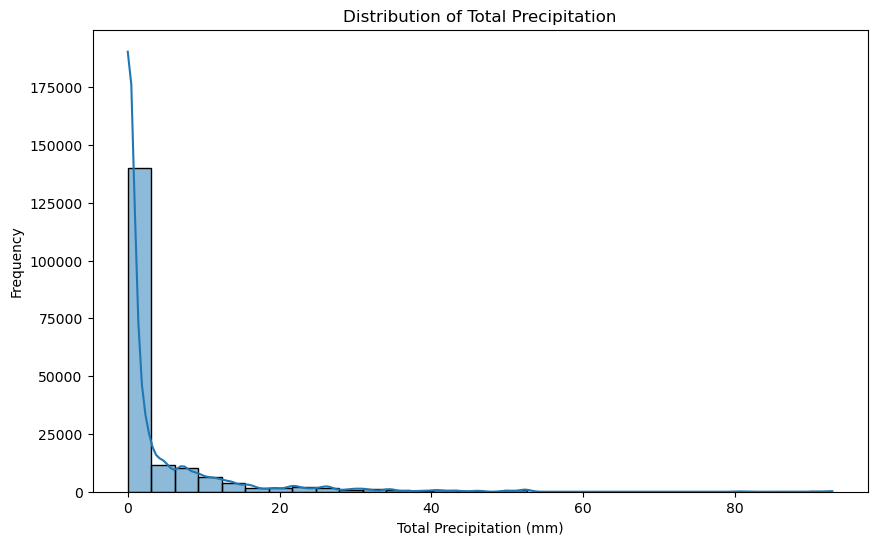

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# as can be seen there some missing values in the TOTAL_PRECIPITATION column
# Histogram to check the distribution of 'TOTAL_PRECIPITATION'
plt.figure(figsize=(10, 6))
sns.histplot(df_event_log_visits['TOTAL_PRECIPITATION'].dropna(), kde=True, bins=30)
plt.title('Distribution of Total Precipitation')
plt.xlabel('Total Precipitation (mm)')
plt.ylabel('Frequency')
plt.show()


In [59]:
# Calculating basic statistics for 'TOTAL_PRECIPITATION'
precipitation_stats = df_event_log_visits['TOTAL_PRECIPITATION'].describe()

print("Statistics for 'TOTAL_PRECIPITATION':")
print(precipitation_stats)


Statistics for 'TOTAL_PRECIPITATION':
count    184078.000000
mean          3.622605
std           8.111443
min           0.000000
25%           0.000000
50%           0.200000
75%           3.000000
max          92.800000
Name: TOTAL_PRECIPITATION, dtype: float64


In [60]:
# Calculating the median for 'TOTAL_PRECIPITATION'
median_precipitation = df_event_log_visits['TOTAL_PRECIPITATION'].median()

# Fill missing values with the median
df_event_log_visits['TOTAL_PRECIPITATION'].fillna(median_precipitation, inplace=True)


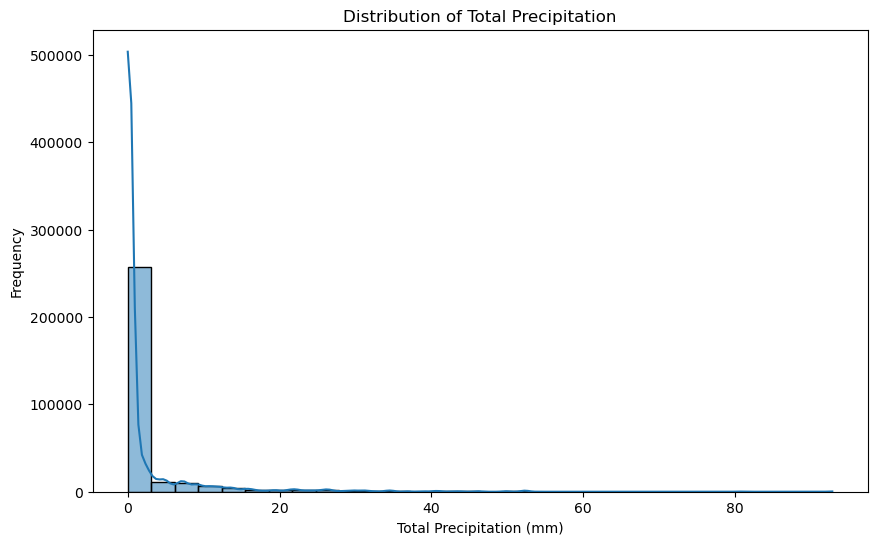

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram to check the distribution of 'TOTAL_PRECIPITATION'
plt.figure(figsize=(10, 6))
sns.histplot(df_event_log_visits['TOTAL_PRECIPITATION'].dropna(), kde=True, bins=30)
plt.title('Distribution of Total Precipitation')
plt.xlabel('Total Precipitation (mm)')
plt.ylabel('Frequency')
plt.show()

In [62]:
# Calculating basic statistics for 'TOTAL_PRECIPITATION'
precipitation_stats = df_event_log_visits['TOTAL_PRECIPITATION'].describe()

print("Statistics for 'TOTAL_PRECIPITATION':")
print(precipitation_stats)


Statistics for 'TOTAL_PRECIPITATION':
count    301205.000000
mean          2.291686
std           6.556978
min           0.000000
25%           0.000000
50%           0.200000
75%           0.700000
max          92.800000
Name: TOTAL_PRECIPITATION, dtype: float64


In [63]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 36 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   SID                    301205 non-null  object             
 1   SEX                    301205 non-null  int64              
 2   DOB                    301205 non-null  datetime64[ns]     
 3   DOD                    11463 non-null   datetime64[ns]     
 4   ED_POSTAL_CODE         301205 non-null  object             
 5   FACILITY_ID            301205 non-null  object             
 6   FACILITY_NAME          301205 non-null  object             
 7   VISIT_ID               301205 non-null  object             
 8   VISIT_AGE              301205 non-null  float64            
 9   CTAS                   301205 non-null  float64            
 10  DEPART_DISPOSITION_ID  300775 non-null  object             
 11  Activity               301205 non-null 

## IMAGING_DONE and LABS_DONE

In [64]:
# Loading the Excel file for imaging data
imaging_data = pd.read_excel("October2023_Data\INC10447_ED_VISIT_IMAGES_20230929.xlsx")

# Loading the CSV file for lab tests data
labs_data = pd.read_csv("October2023_Data\INC10447_ED_VISIT_LABS_20230929.csv")

# Displaying the first few rows to ensure correct data loading
print("Imaging Data:")
print(imaging_data.head())
print("Labs Data:")
print(labs_data.head())

Imaging Data:
          SID   ED_VISIT_ID ED_SERVICE_DATE IMAGE_REPORTED_DATE  \
0  STDY111111  VISIT2102120      2021-07-12          2021-07-12   
1  STDY111113  VISIT1942974      2020-05-26          2020-05-27   
2  STDY111113  VISIT1942974      2020-05-26          2020-05-27   
3  STDY111115  VISIT1996593      2020-10-08          2020-10-08   
4  STDY111116  VISIT1424440      2017-03-19          2017-03-19   

     IMAGE_TEST_NAME  
0  CHEST DUAL ENERGY  
1          HAND LEFT  
2      SCAPHOID LEFT  
3          FOOT LEFT  
4   CHEST PA+LATERAL  
Labs Data:
          SID   ED_VISIT_ID ED_SERVICE_DATE LAB_REPORTED_DATE    LAB_TEST_NAME
0  STDY111111  VISIT2102120     12-JUL-2021       12-JUL-2021        ANION GAP
1  STDY111111  VISIT2102120     12-JUL-2021       12-JUL-2021  BILIRUBIN;TOTAL
2  STDY111111  VISIT2102120     12-JUL-2021       12-JUL-2021              CBC
3  STDY111111  VISIT2102120     12-JUL-2021       12-JUL-2021         CHLORIDE
4  STDY111111  VISIT2102120     12-JUL-

In [65]:
# Checking for duplicates in the 'ED_VISIT_ID' column of each dataset
print("Duplicate ED_VISIT_ID in imaging data:", imaging_data['ED_VISIT_ID'].duplicated().sum())
print("Duplicate ED_VISIT_ID in labs data:", labs_data['ED_VISIT_ID'].duplicated().sum())


Duplicate ED_VISIT_ID in imaging data: 140909
Duplicate ED_VISIT_ID in labs data: 4424233


In [66]:
# Dropping duplicates based on 'ED_VISIT_ID'
imaging_data = imaging_data.drop_duplicates(subset=['ED_VISIT_ID'], keep='first')
labs_data = labs_data.drop_duplicates(subset=['ED_VISIT_ID'], keep='first')


In [67]:
# Merging based on 'ED_VISIT_ID'
df_event_log_visits = pd.merge(
    df_event_log_visits,
    imaging_data[['ED_VISIT_ID']],  
    left_on='VISIT_ID', 
    right_on='ED_VISIT_ID',
    how='left', 
    indicator='Imaging_Merge_Indicator'
)

# Creating a new column to indicate if imaging was done
df_event_log_visits['Imaging_Done'] = df_event_log_visits['Imaging_Merge_Indicator'].apply(lambda x: x == 'both')



In [68]:
# Merging based on 'ED_VISIT_ID'
df_event_log_visits = pd.merge(
    df_event_log_visits,
    labs_data[['ED_VISIT_ID']],  
    left_on='VISIT_ID',
    right_on='ED_VISIT_ID',
    how='left',
    indicator='Labs_Merge_Indicator'
)

# Creating a new column to indicate if lab tests were done
df_event_log_visits['Labs_Done'] = df_event_log_visits['Labs_Merge_Indicator'].apply(lambda x: x == 'both')


In [69]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   SID                      301205 non-null  object             
 1   SEX                      301205 non-null  int64              
 2   DOB                      301205 non-null  datetime64[ns]     
 3   DOD                      11463 non-null   datetime64[ns]     
 4   ED_POSTAL_CODE           301205 non-null  object             
 5   FACILITY_ID              301205 non-null  object             
 6   FACILITY_NAME            301205 non-null  object             
 7   VISIT_ID                 301205 non-null  object             
 8   VISIT_AGE                301205 non-null  float64            
 9   CTAS                     301205 non-null  float64            
 10  DEPART_DISPOSITION_ID    300775 non-null  object             
 11  Activity     

## Deleting columns that were created during the creation of new features and are not needed anymore

In [70]:
# List of columns to drop
columns_to_drop = ['FACILITY_NAME',
    'Area_Type', 
    'Country', 
    'Postal_Code', 
    'Place_Name', 
    'Province', 
    'Province_Code', 
    'First_3_Digits', 
    'Date', 
      'ED_VISIT_ID_x', 'Imaging_Merge_Indicator', 'ED_VISIT_ID_y', 'Labs_Merge_Indicator'
]

# Dropping the specified columns
df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

# Displaying the updated DataFrame to confirm the changes
print(df_event_log_visits.head())


          SID  SEX        DOB DOD ED_POSTAL_CODE FACILITY_ID      VISIT_ID  \
0  STDY147061    1 1959-07-14 NaT        A0A 2B0         CGH  VISIT2208402   
1  STDY147061    1 1959-07-14 NaT        A0A 2B0         CGH  VISIT2208402   
2  STDY147061    1 1959-07-14 NaT        A0A 2B0         CGH  VISIT2208402   
3  STDY147061    1 1959-07-14 NaT        A0A 2B0         CGH  VISIT2208402   
4  STDY321073    0 1999-02-08 NaT        A1B 1Z6         HSC  VISIT2208404   

   VISIT_AGE  CTAS DEPART_DISPOSITION_ID  ... Is_NL_Holiday Day_of_Week  \
0  62.750000   3.0                     D  ...         False           4   
1  62.750000   3.0                     D  ...         False           4   
2  62.750000   3.0                     D  ...         False           4   
3  62.750000   3.0                     D  ...         False           4   
4  23.166667   4.0                     D  ...         False           4   

  Is_Weekend  Visit_Season Visit_Frequency  Prior_LWBS  ED_Business_Hourly  \
0 

In [71]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   SID                    301205 non-null  object             
 1   SEX                    301205 non-null  int64              
 2   DOB                    301205 non-null  datetime64[ns]     
 3   DOD                    11463 non-null   datetime64[ns]     
 4   ED_POSTAL_CODE         301205 non-null  object             
 5   FACILITY_ID            301205 non-null  object             
 6   VISIT_ID               301205 non-null  object             
 7   VISIT_AGE              301205 non-null  float64            
 8   CTAS                   301205 non-null  float64            
 9   DEPART_DISPOSITION_ID  300775 non-null  object             
 10  Activity               301205 non-null  object             
 11  Start_Time             301205 non-null 

In [72]:
# Dropping the 'ED_POSTAL_CODE' column 
df_event_log_visits.drop(columns=['ED_POSTAL_CODE'], inplace=True)


In [73]:
# One-Hot Encoding for 'FACILITY_ID'
df_event_log_visits = pd.get_dummies(df_event_log_visits, columns=['FACILITY_ID'])


In [74]:
from sklearn.preprocessing import OrdinalEncoder

# Ordinal Encoding for 'Activity'
ordinal_encoder = OrdinalEncoder()

# Fitting the encoder to 'Activity' and transform it
df_event_log_visits['Activity_Encoded'] = ordinal_encoder.fit_transform(df_event_log_visits[['Activity']])


In [75]:
# Creating a binary outcome for 'DEPART_DISPOSITION'
df_event_log_visits['Is_LWBS'] = df_event_log_visits['DEPART_DISPOSITION_ID'].isin(['TLWBS', 'RLWBS']).astype(int)


In [76]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   SID                    301205 non-null  object             
 1   SEX                    301205 non-null  int64              
 2   DOB                    301205 non-null  datetime64[ns]     
 3   DOD                    11463 non-null   datetime64[ns]     
 4   VISIT_ID               301205 non-null  object             
 5   VISIT_AGE              301205 non-null  float64            
 6   CTAS                   301205 non-null  float64            
 7   DEPART_DISPOSITION_ID  300775 non-null  object             
 8   Activity               301205 non-null  object             
 9   Start_Time             301205 non-null  datetime64[ns, UTC]
 10  End_Time               223223 non-null  object             
 11  Duration_hours         301205 non-null 

In [77]:
# Dropping original columns after encoding
columns_to_drop = ['Activity']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)


In [78]:
# Converting 'End_Time' to datetime
df_event_log_visits['End_Time'] = pd.to_datetime(df_event_log_visits['End_Time'], errors='coerce')


In [79]:
from sklearn.preprocessing import OrdinalEncoder

# Defining the order for 'TIME_OF_THE_DAY'
time_order = [['Early Morning to Morning', 'Late Morning to Late Afternoon','Evening to Night']]

# Creating an OrdinalEncoder with the specified order
ordinal_encoder = OrdinalEncoder(categories=time_order)

# Applying the encoder to 'TIME_OF_THE_DAY'
df_event_log_visits['TIME_OF_THE_DAY_Ordinal'] = ordinal_encoder.fit_transform(df_event_log_visits[['TIME_OF_THE_DAY']])


In [80]:
columns_to_drop = ['TIME_OF_THE_DAY']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

In [81]:
# Defining the order for 'Visit_Season'
season_order = [['Winter', 'Spring', 'Summer', 'Fall']]

# Creating an OrdinalEncoder with the specified order
ordinal_encoder = OrdinalEncoder(categories=season_order)

# Applying the encoder to 'Visit_Season'
df_event_log_visits['Visit_Season_Ordinal'] = ordinal_encoder.fit_transform(df_event_log_visits[['Visit_Season']])


In [82]:
columns_to_drop = ['Visit_Season']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

In [83]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   SID                      301205 non-null  object             
 1   SEX                      301205 non-null  int64              
 2   DOB                      301205 non-null  datetime64[ns]     
 3   DOD                      11463 non-null   datetime64[ns]     
 4   VISIT_ID                 301205 non-null  object             
 5   VISIT_AGE                301205 non-null  float64            
 6   CTAS                     301205 non-null  float64            
 7   DEPART_DISPOSITION_ID    300775 non-null  object             
 8   Start_Time               301205 non-null  datetime64[ns, UTC]
 9   End_Time                 223223 non-null  datetime64[ns, UTC]
 10  Duration_hours           301205 non-null  float64            
 11  Is_Deceased  

## changes discussed at todays meeting 2024/04/29

In [84]:
# changes discussed at todays meeting 2024/04/29
columns_to_drop = ['DOB', 'DOD', 'Latitude', 'Longitude']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

In [85]:
# Calculating the duration of each activity in hours
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])
df_event_log_visits['End_Time'] = pd.to_datetime(df_event_log_visits['End_Time'])

df_event_log_visits['Activity_Duration'] = (df_event_log_visits['End_Time'] - df_event_log_visits['Start_Time']).dt.total_seconds() / 3600
print(df_event_log_visits.head())

          SID  SEX      VISIT_ID  VISIT_AGE  CTAS DEPART_DISPOSITION_ID  \
0  STDY147061    1  VISIT2208402  62.750000   3.0                     D   
1  STDY147061    1  VISIT2208402  62.750000   3.0                     D   
2  STDY147061    1  VISIT2208402  62.750000   3.0                     D   
3  STDY147061    1  VISIT2208402  62.750000   3.0                     D   
4  STDY321073    0  VISIT2208404  23.166667   4.0                     D   

                 Start_Time                  End_Time  Duration_hours  \
0 2022-04-01 00:22:00+00:00 2022-04-01 00:24:00+00:00        0.550000   
1 2022-04-01 00:24:00+00:00 2022-04-01 00:30:00+00:00        0.550000   
2 2022-04-01 00:30:00+00:00 2022-04-01 00:55:00+00:00        0.550000   
3 2022-04-01 00:55:00+00:00                       NaT        0.550000   
4 2022-04-01 00:40:00+00:00 2022-04-01 00:44:00+00:00        5.333333   

   Is_Deceased  ...  FACILITY_ID_BUR  FACILITY_ID_CGH  FACILITY_ID_GBC  \
0            0  ...            False

In [86]:
# Display the first few rows with the correct column names
df_event_log_visits[['VISIT_ID', 'Start_Time', 'End_Time', 'Activity_Duration']].head(10)


,VISIT_ID,Start_Time,End_Time,Activity_Duration
0,VISIT2208402,2022-04-01 00:22:00+00:00,2022-04-01 00:24:00+00:00,0.033333
1,VISIT2208402,2022-04-01 00:24:00+00:00,2022-04-01 00:30:00+00:00,0.100000
2,VISIT2208402,2022-04-01 00:30:00+00:00,2022-04-01 00:55:00+00:00,0.416667
3,VISIT2208402,2022-04-01 00:55:00+00:00,NaT,NaN
4,VISIT2208404,2022-04-01 00:40:00+00:00,2022-04-01 00:44:00+00:00,0.066667
5,VISIT2208404,2022-04-01 00:44:00+00:00,2022-04-01 05:30:00+00:00,4.766667
6,VISIT2208404,2022-04-01 05:30:00+00:00,2022-04-01 06:00:00+00:00,0.500000
7,VISIT2208404,2022-04-01 06:00:00+00:00,NaT,NaN
8,VISIT2208406,2022-04-01 01:03:00+00:00,2022-04-01 01:05:00+00:00,0.033333
9,VISIT2208406,2022-04-01 01:05:00+00:00,2022-04-01 05:30:00+00:00,4.416667


In [87]:
# dropping start and end times as they are no longer needed
columns_to_drop = ['Start_Time', 'End_Time']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

# Renaming the 'Duration_hours' column to 'Case_Duration_Hours'
df_event_log_visits.rename(columns={'Duration_hours': 'Case_Duration_Hours'}, inplace=True)




In [88]:

df_event_log_visits.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      301205 non-null  object 
 1   SEX                      301205 non-null  int64  
 2   VISIT_ID                 301205 non-null  object 
 3   VISIT_AGE                301205 non-null  float64
 4   CTAS                     301205 non-null  float64
 5   DEPART_DISPOSITION_ID    300775 non-null  object 
 6   Case_Duration_Hours      301205 non-null  float64
 7   Is_Deceased              301205 non-null  int32  
 8   Distance_to_Hospital     301205 non-null  float64
 9   Is_NL_Holiday            301205 non-null  bool   
 10  Day_of_Week              301205 non-null  int32  
 11  Is_Weekend               301205 non-null  bool   
 12  Visit_Frequency          301205 non-null  int64  
 13  Prior_LWBS               301205 non-null  float64
 14  ED_B

In [89]:
# Counting occurrences of each 'DEPART_DISPOSITION_ID' within each 'SID'
disposition_counts = df_event_log_visits.groupby(['SID', 'DEPART_DISPOSITION_ID']).size()

# Converting the series to a DataFrame
disposition_counts = disposition_counts.reset_index(name='Counts')

# Calculating total occurrences of dispositions per 'SID'
total_dispositions_per_sid = disposition_counts.groupby('SID')['Counts'].transform('sum')

# Calculating frequency of each disposition within each SID
disposition_counts['Disposition_Frequency'] = disposition_counts['Counts'] / total_dispositions_per_sid

# Merging this frequency back to the original DataFrame
df_event_log_visits = df_event_log_visits.merge(disposition_counts[['SID', 'DEPART_DISPOSITION_ID', 'Disposition_Frequency']], on=['SID', 'DEPART_DISPOSITION_ID'], how='left')

# Displaying the first few rows to verify the changes
df_event_log_visits[['SID', 'DEPART_DISPOSITION_ID', 'Disposition_Frequency']].head()


,SID,DEPART_DISPOSITION_ID,Disposition_Frequency
0,STDY147061,D,0.714286
1,STDY147061,D,0.714286
2,STDY147061,D,0.714286
3,STDY147061,D,0.714286
4,STDY321073,D,1.000000


In [90]:
columns_to_drop = ['DEPART_DISPOSITION_ID']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

In [91]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      301205 non-null  object 
 1   SEX                      301205 non-null  int64  
 2   VISIT_ID                 301205 non-null  object 
 3   VISIT_AGE                301205 non-null  float64
 4   CTAS                     301205 non-null  float64
 5   Case_Duration_Hours      301205 non-null  float64
 6   Is_Deceased              301205 non-null  int32  
 7   Distance_to_Hospital     301205 non-null  float64
 8   Is_NL_Holiday            301205 non-null  bool   
 9   Day_of_Week              301205 non-null  int32  
 10  Is_Weekend               301205 non-null  bool   
 11  Visit_Frequency          301205 non-null  int64  
 12  Prior_LWBS               301205 non-null  float64
 13  ED_Business_Hourly       301205 non-null  int64  
 14  TOTA

In [92]:
# TOTAL_PRECIPITATION - keep or delete? there is a lot of missing values i needed to fill

In [ ]:
# Save to CSV
df_event_log_visits.to_csv('df_event_log_visits_for_ML.csv', index=False)
